In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch.utils.data
import torchgeo.datasets.utils
from sklearn.neighbors import NearestNeighbors


import pretraining.unsupervised.moco

['weights', 'augmentation1', 'augmentation2']


In [2]:
model_imnet = timm.create_model("resnet18", in_chans=7, num_classes=0, pretrained=False)
model_imnet.eval()

model_moco = timm.create_model("resnet18", in_chans=7, num_classes=0, pretrained=False)
model_moco.load_state_dict(torch.load("unsupervised/resnet18_mocov3_v0"))
model_moco.eval()

model_rand = timm.create_model("resnet18", in_chans=7, num_classes=0, pretrained=True)
model_rand.eval()

ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [3]:
dataset = pretraining.test.ChipDataset(dirpath=r"C:\Documents\RoofSense\dataset\imgs", cache=False)

dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=torchgeo.datasets.stack_samples,
                                         pin_memory=True,
                                         drop_last=False,
                                         generator=torch.Generator().manual_seed(0),
                                         persistent_workers=False, )

In [4]:
from augmentations.feature import MinMaxScaling

aug = MinMaxScaling(mins=torch.tensor([0, 0, 0, 0, 0, -100, 0]),
                                         maxs=torch.tensor([255, 255, 255, 1, 90, 100, 100]))

embeddings_imnet = []
embeddings_moco = []
embeddings_rand = []
with torch.inference_mode():
    for batch in dataloader:
        image = aug(batch["image"])
        embeddings_imnet.append(model_imnet(image))
        embeddings_moco.append(model_moco(image))
        embeddings_rand.append(model_rand(image))
embeddings_imnet = torch.cat(embeddings_imnet)
embeddings_moco = torch.cat(embeddings_moco)
embeddings_rand = torch.cat(embeddings_rand)

In [12]:
nbr_model_imnet = NearestNeighbors(n_neighbors=3, metric="euclidean", n_jobs=-1).fit(embeddings_imnet)
nbr_model_moco = NearestNeighbors(n_neighbors=3, metric="euclidean", n_jobs=-1).fit(embeddings_moco)
nbr_model_rand = NearestNeighbors(n_neighbors=3, metric="euclidean", n_jobs=-1).fit(embeddings_rand)

dists, idxs = nbr_model_moco.kneighbors(embeddings_moco)

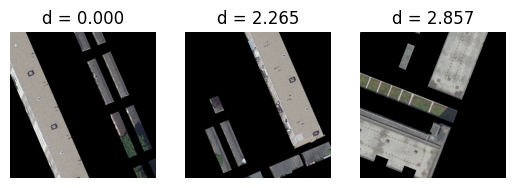

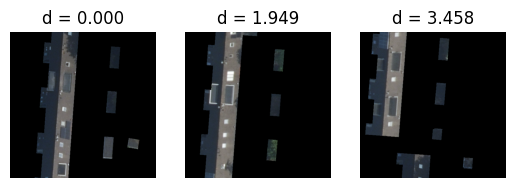

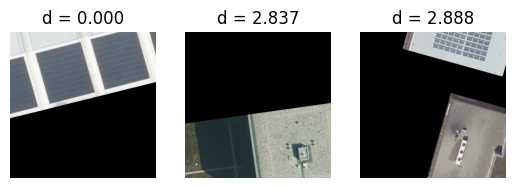

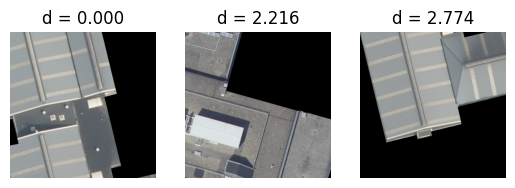

In [13]:
# sample_idxs = np.random.choice(len(idxs), size=4, replace=False)
sample_idxs = np.array([68,147,16,2])

for idx in sample_idxs:
    fig = plt.figure()
    for nbr_loc_idx, neighbor_glob_idx in enumerate(idxs[idx]):
        ax = fig.add_subplot(1, len(idxs[idx]), nbr_loc_idx + 1)
        plt.imshow(torch.moveaxis(# Get the RGB component of the image.
            (dataset[neighbor_glob_idx]["image"][:3, ...]).to(torch.int32), 0, -1))
        ax.set_title(f"d = {dists[idx][nbr_loc_idx]:.3f}")
        plt.axis("off")